In [1]:
1+2

3

# Test networkx library

In [3]:
!pip install networkx

     |████████████████████████████████| 1.9 MB 2.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import networkx as nx

In [31]:
g = nx.erdos_renyi_graph(10, 0.15)

In [9]:
g.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))

In [12]:
g.edges

EdgeView([(1, 4), (1, 8), (3, 7), (4, 7), (4, 8), (6, 9), (7, 8)])

In [13]:
g.adjacency()

In [24]:
g.adj

AdjacencyView({0: {}, 1: {4: {}, 8: {}}, 2: {}, 3: {7: {}}, 4: {1: {}, 7: {}, 8: {}}, 5: {}, 6: {9: {}}, 7: {3: {}, 4: {}, 8: {}}, 8: {1: {}, 4: {}, 7: {}}, 9: {6: {}}})

In [2]:
import matplotlib.pyplot as plt

In [114]:
g = nx.erdos_renyi_graph(10, 0.1, directed=True)

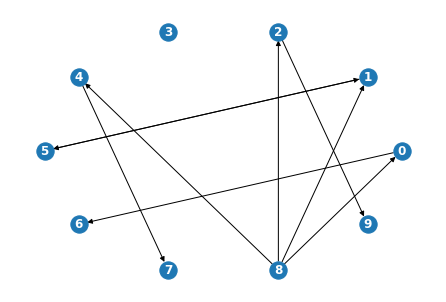

In [115]:
nx.draw_circular(g, with_labels=True, font_weight='bold', font_color='white')

In [116]:
len(g.edges)

9

In [117]:
g = nx.barabasi_albert_graph(10, 1, directed=True)

TypeError: argmap_barabasi_albert_graph_25() got an unexpected keyword argument 'directed'

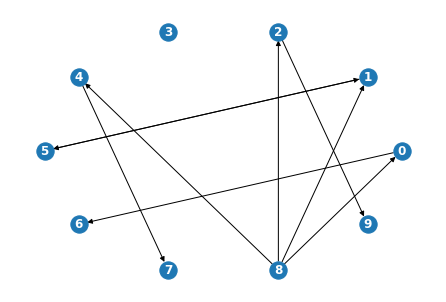

In [118]:
nx.draw_circular(g, with_labels=True, font_weight='bold', font_color='white')

In [101]:
len(g.edges)

9

In [119]:
!pip install igraph

     |████████████████████████████████| 3.2 MB 2.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import igraph as ig

In [4]:
import numpy as np

In [5]:
def simulate_dag(d, s0, graph_type):
    """Simulate random DAG with some expected number of edges.

    Args:
        d (int): num of nodes
        s0 (int): expected num of edges
        graph_type (str): ER, SF, BP

    Returns:
        B (np.ndarray): [d, d] binary adj matrix of DAG
    """
    def _random_permutation(M):
        # np.random.permutation permutes first axis only
        P = np.random.permutation(np.eye(M.shape[0]))
        return P.T @ M @ P

    def _random_acyclic_orientation(B_und):
        return np.tril(_random_permutation(B_und), k=-1)

    def _graph_to_adjmat(G):
        return np.array(G.get_adjacency().data)

    if graph_type == 'ER':
        # Erdos-Renyi
        G_und = ig.Graph.Erdos_Renyi(n=d, m=s0)
        B_und = _graph_to_adjmat(G_und)
        B = _random_acyclic_orientation(B_und)
    elif graph_type == 'SF':
        # Scale-free, Barabasi-Albert
        G = ig.Graph.Barabasi(n=d, m=int(round(s0 / d)), directed=True)
        B = _graph_to_adjmat(G)
    elif graph_type == 'BP':
        # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
        top = int(0.2 * d)
        G = ig.Graph.Random_Bipartite(top, d - top, m=s0, directed=True, neimode=ig.OUT)
        B = _graph_to_adjmat(G)
    else:
        raise ValueError('unknown graph type')
    B_perm = _random_permutation(B)
    assert ig.Graph.Adjacency(B_perm.tolist()).is_dag()
    return B_perm

In [6]:
adj = simulate_dag(10, 10, 'SF')
adj

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

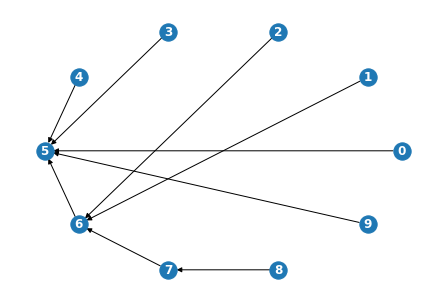

In [142]:
nx.draw_circular(nx.DiGraph(adj), with_labels=True, font_weight='bold', font_color='white')

In [7]:
def mydraw(adj):
    nx.draw_circular(nx.DiGraph(adj), with_labels=True, font_weight='bold', font_color='white')

# Generate Training data

In [14]:
import random
import os

In [15]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

In [16]:
def is_dag(W):
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.is_dag()

In [17]:
def count_accuracy(B_true, B_est):
    """Compute various accuracy metrics for B_est.

    true positive = predicted association exists in condition in correct direction
    reverse = predicted association exists in condition in opposite direction
    false positive = predicted association does not exist in condition

    Args:
        B_true (np.ndarray): [d, d] ground truth graph, {0, 1}
        B_est (np.ndarray): [d, d] estimate, {0, 1, -1}, -1 is undirected edge in CPDAG

    Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        fpr: (reverse + false positive) / condition negative
        shd: undirected extra + undirected missing + reverse
        nnz: prediction positive
    """
    if (B_est == -1).any():  # cpdag
        if not ((B_est == 0) | (B_est == 1) | (B_est == -1)).all():
            raise ValueError('B_est should take value in {0,1,-1}')
        if ((B_est == -1) & (B_est.T == -1)).any():
            raise ValueError('undirected edge should only appear once')
    else:  # dag
        if not ((B_est == 0) | (B_est == 1)).all():
            raise ValueError('B_est should take value in {0,1}')
        if not is_dag(B_est):
            raise ValueError('B_est should be a DAG')
    d = B_true.shape[0]
    # linear index of nonzeros
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    # treat undirected edge favorably
    true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
    true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
    false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred) + len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)
    # structural hamming distance
    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return {'fdr': fdr, 'tpr': tpr, 'fpr': fpr, 'shd': shd, 'nnz': pred_size}

In [ ]:
# 1. generate graph
# 2. simulate linear SEM
# 3. [optional] generate data
# 4. compute COV

In [8]:
def simulate_parameter(B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        w_ranges (tuple): disjoint weight ranges

    Returns:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
    """
    W = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        W += B * (S == i) * U
    return W

In [9]:
def simulate_linear_sem(W, n, sem_type, noise_scale=None):
    """Simulate samples from linear SEM with specified type of noise.

    For uniform, noise z ~ uniform(-a, a), where a = noise_scale.

    Args:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
        n (int): num of samples, n=inf mimics population risk
        sem_type (str): gauss, exp, gumbel, uniform, logistic, poisson
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix, [d, d] if n=inf
    """
    def _simulate_single_equation(X, w, scale):
        """X: [n, num of parents], w: [num of parents], x: [n]"""
        if sem_type == 'gauss':
            z = np.random.normal(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'exp':
            z = np.random.exponential(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'gumbel':
            z = np.random.gumbel(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'uniform':
            z = np.random.uniform(low=-scale, high=scale, size=n)
            x = X @ w + z
        elif sem_type == 'logistic':
            x = np.random.binomial(1, sigmoid(X @ w)) * 1.0
        elif sem_type == 'poisson':
            x = np.random.poisson(np.exp(X @ w)) * 1.0
        else:
            raise ValueError('unknown sem type')
        return x

    d = W.shape[0]
    if noise_scale is None:
        scale_vec = np.ones(d)
    elif np.isscalar(noise_scale):
        scale_vec = noise_scale * np.ones(d)
    else:
        if len(noise_scale) != d:
            raise ValueError('noise scale must be a scalar or has length d')
        scale_vec = noise_scale
    if not is_dag(W):
        raise ValueError('W must be a DAG')
    if np.isinf(n):  # population risk for linear gauss SEM
        if sem_type == 'gauss':
            # make 1/d X'X = true cov
            X = np.sqrt(d) * np.diag(scale_vec) @ np.linalg.inv(np.eye(d) - W)
            return X
        else:
            raise ValueError('population risk not available')
    # empirical risk
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    X = np.zeros([n, d])
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
    return X

In [646]:
def simulate_nonlinear_sem(B, n, sem_type, noise_scale=None):
    """Simulate samples from nonlinear SEM.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        n (int): num of samples
        sem_type (str): mlp, mim, gp, gp-add
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix
    """
    def _simulate_single_equation(X, scale):
        """X: [n, num of parents], x: [n]"""
        z = np.random.normal(scale=scale, size=n)
        pa_size = X.shape[1]
        if pa_size == 0:
            return z
        if sem_type == 'mlp':
            hidden = 100
            W1 = np.random.uniform(low=0.5, high=2.0, size=[pa_size, hidden])
            W1[np.random.rand(*W1.shape) < 0.5] *= -1
            W2 = np.random.uniform(low=0.5, high=2.0, size=hidden)
            W2[np.random.rand(hidden) < 0.5] *= -1
            x = sigmoid(X @ W1) @ W2 + z
        elif sem_type == 'mim':
            w1 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w1[np.random.rand(pa_size) < 0.5] *= -1
            w2 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w2[np.random.rand(pa_size) < 0.5] *= -1
            w3 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w3[np.random.rand(pa_size) < 0.5] *= -1
            x = np.tanh(X @ w1) + np.cos(X @ w2) + np.sin(X @ w3) + z
        elif sem_type == 'gp':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = gp.sample_y(X, random_state=None).flatten() + z
        elif sem_type == 'gp-add':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = sum([gp.sample_y(X[:, i, None], random_state=None).flatten()
                     for i in range(X.shape[1])]) + z
        else:
            raise ValueError('unknown sem type')
        return x

    d = B.shape[0]
    scale_vec = noise_scale if noise_scale else np.ones(d)
    X = np.zeros([n, d])
    G = ig.Graph.Adjacency(B.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], scale_vec[j])
    return X


In [186]:
# generate a graph
g = simulate_dag(10, 10, 'ER')

In [188]:
g

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

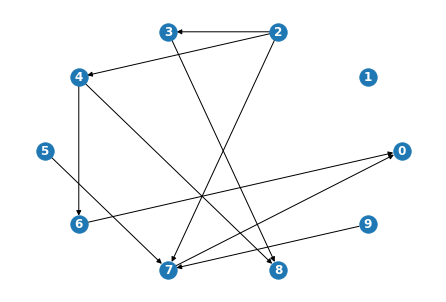

In [189]:
mydraw(g)

In [220]:
W_true = simulate_parameter(g, w_ranges=((-2,-0.5), (0.5,2)))
W_true

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -1.9669171 ,  1.71557088,
         0.        ,  0.        ,  1.75311747,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -1.1230839 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.03816648,  0.        , -1.52996384,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.66512365,  0.        ,  0.        ],
       [ 1.27042091,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        

In [221]:
(W_true != 0).astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [194]:
W_true.shape

(10, 10)

In [806]:
X = simulate_linear_sem(W_true, 1000, 'gauss')

In [807]:
X.shape

(1000, 10)

In [808]:
np.cov(np.transpose(X)).shape

(10, 10)

In [812]:
np.corrcoef(np.transpose(X))

array([[ 1.        , -0.01476883,  0.81410078, -0.73694228,  0.79245941,
         0.42781672,  0.79794822,  0.90663783, -0.27740102,  0.12495126],
       [-0.01476883,  1.        , -0.00185557,  0.01407932,  0.005927  ,
        -0.04411986,  0.02210718, -0.03166386, -0.04801895, -0.00842025],
       [ 0.81410078, -0.00185557,  1.        , -0.89586198,  0.87113243,
         0.04134199,  0.80114738,  0.66506583, -0.1935011 , -0.04686674],
       [-0.73694228,  0.01407932, -0.89586198,  1.        , -0.78411636,
        -0.06096693, -0.72525659, -0.60506808, -0.04649056,  0.04339608],
       [ 0.79245941,  0.005927  ,  0.87113243, -0.78411636,  1.        ,
         0.02822543,  0.89861991,  0.56805317, -0.51781375, -0.04966296],
       [ 0.42781672, -0.04411986,  0.04134199, -0.06096693,  0.02822543,
         1.        ,  0.01773774,  0.6260674 ,  0.00831555, -0.0075637 ],
       [ 0.79794822,  0.02210718,  0.80114738, -0.72525659,  0.89861991,
         0.01773774,  1.        ,  0.50716706

In [819]:
vars = np.var(np.transpose(X), axis=1)
vars

array([42.861967  ,  1.03596353,  1.04430522,  5.16506862,  4.16057272,
        0.97442512,  5.6305942 ,  7.52172496,  4.80405376,  1.00640089])

In [820]:
np.var(X[:,0])

42.861967003675296

In [799]:
np.diag((vars - np.mean(vars)) / np.std(vars))

array([[-0.44688154,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.78556927,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.75833757,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.23736171,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.47027809,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.44164628,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.33154485,  0.        

In [10]:
def get_my_normalized_cov(X):
    cor = np.corrcoef(np.transpose(X))
    vars = np.var(np.transpose(X), axis=1)
    return np.stack((cor, np.diag((vars - np.mean(vars)) / np.std(vars))))

In [831]:
get_my_normalized_cov(X).shape

(2, 10, 10)

In [657]:
def gen_train_data():
    # generate 1000 graphs
    # for each graph, generate data
    ngraphs = 1000
    res_X = []
    res_Y = []
    for _ in range(ngraphs):
        g = simulate_dag(10, 30, 'ER')
        # W_true = simulate_parameter(g, w_ranges=((-2,-0.5), (0.5,2)))
        # X = simulate_linear_sem(W_true, 1000, 'gauss')
        X = simulate_nonlinear_sem(g, 1000, 'mim')
        # cov = np.cov(np.transpose(X))
        cov = get_my_normalized_cov(X)
        res_X.append(cov)
        # res_Y.append((W_true != 0).astype('float32'))
        res_Y.append(g.astype('float32'))
    return np.array(res_X), np.array(res_Y)

In [658]:
X, Y = gen_train_data()

In [659]:
def split(X, Y):
    mid = int(X.shape[0] * 0.8)
    return X[:mid], Y[:mid], X[mid:], Y[mid:]

In [660]:
X_train, Y_train, X_test, Y_test = split(X, Y)

In [661]:
X.shape

(1000, 2, 10, 10)

In [662]:
X_train.shape

(800, 2, 10, 10)

In [663]:
Y.shape

(1000, 10, 10)

# build the models

In [ ]:
# 1. FC
# 2. CNN
# 3. add regularization
# 4. EQ models
# 5. EQ model with 11 params

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [666]:
model = keras.Sequential(
    [
        layers.Reshape((10*10*2,)),
        layers.Dense(1000, activation="relu", name="layer1"),
        layers.Dense(1000, activation="relu", name="layer2"),
        layers.Dense(10*10, activation='sigmoid', name="layer3"),
        layers.Reshape((10,10)),
    ]
)

In [667]:
model(X).shape

TensorShape([1000, 10, 10])

In [668]:
out = model(X)

In [669]:
Y[0]

array([[0., 0., 0., 1., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 1., 1., 1., 1.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]], dtype=float32)

In [670]:
is_dag(out[0].numpy() > 0.5)

False

In [671]:
is_dag(Y[0])

True

In [672]:
Y.shape

(1000, 10, 10)

In [673]:
out.shape

TensorShape([1000, 10, 10])

In [89]:
cce = keras.losses.BinaryCrossentropy(from_logits=True)

In [90]:
cce(out, Y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7052073>

In [91]:
# train!!

In [92]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (1000, 200)               0         
                                                                 
 layer1 (Dense)              (1000, 1000)              201000    
                                                                 
 layer2 (Dense)              (1000, 1000)              1001000   
                                                                 
 layer3 (Dense)              (1000, 100)               100100    
                                                                 
 reshape_9 (Reshape)         (1000, 10, 10)            0         
                                                                 
Total params: 1,302,100
Trainable params: 1,302,100
Non-trainable params: 0
_________________________________________________________________


In [469]:
out = model(X)

In [ ]:
E = tf.linalg.expm(out * out)
E[0]

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[2.3600368, 1.2779982, 1.2393419, 1.0470486, 1.2965974, 1.0584528,
        1.2681376, 1.2711154, 1.3427086, 1.2774348],
       [1.3095416, 2.1196969, 1.1331363, 1.0525819, 1.2209436, 1.0454892,
        1.3687276, 1.3357267, 1.4086597, 1.2107832],
       [1.3271095, 1.3345295, 2.2971249, 1.2451144, 1.33559  , 1.1290313,
        1.482572 , 1.3725858, 1.3566113, 1.3691847],
       [1.1989939, 1.3148805, 1.243317 , 1.9861344, 1.2100229, 1.1180024,
        1.265945 , 1.2516938, 1.3458617, 1.2369596],
       [1.4367038, 1.3121494, 1.2960266, 1.1298798, 2.2332928, 1.1072556,
        1.3481925, 1.3275181, 1.2557557, 1.3771107],
       [1.2346811, 1.1776712, 1.0866998, 1.0324448, 1.1836052, 2.1065989,
        1.1928662, 1.2248379, 1.2322356, 1.2026082],
       [1.3172832, 1.1142346, 1.1361341, 1.0218209, 1.1765629, 1.0119493,
        2.2183883, 1.2660733, 1.2043775, 1.1200073],
       [1.2989748, 1.2511904, 1.2033011, 1.0696673, 1.2616506

In [645]:
h = tf.linalg.trace(E) - 10
h.shape

TensorShape([1000])

In [470]:
with tf.GradientTape() as tape:
    out = model(X)
    loss = myloss(out, Y)
    # loss = acyclic_h(out)
gradients = tape.gradient(loss, model.trainable_variables)
gradients

[<tf.Tensor: shape=(200, 1000), dtype=float32, numpy=
 array([[ -385.7457   ,  1373.4868   , -1402.0669   , ...,   518.62555  ,
          -136.75006  ,   -95.63164  ],
        [  -75.83084  ,   -22.038294 ,    90.85831  , ...,    35.190258 ,
           -41.25609  ,    21.393969 ],
        [   -2.2484317,   -59.95217  ,   -49.177208 , ...,    73.732086 ,
           -34.358524 ,   -21.47167  ],
        ...,
        [    0.       ,     0.       ,     0.       , ...,     0.       ,
             0.       ,     0.       ],
        [    0.       ,     0.       ,     0.       , ...,     0.       ,
             0.       ,     0.       ],
        [  -26.176054 ,    69.73338  ,   174.06854  , ...,   -31.487387 ,
           -36.925518 ,    -3.2499595]], dtype=float32)>,
 <tf.Tensor: shape=(1000,), dtype=float32, numpy=
 array([-3.85745789e+02,  1.37348621e+03, -1.40206677e+03,  2.63954258e+00,
        -5.05266235e+02, -1.27115515e+03, -8.87980408e+02,  3.97516937e+02,
         7.16412903e+02, -3.3

In [674]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # loss=myloss
    # List of metrics to monitor
    # metrics=[keras.metrics.BinaryAccuracy()],
)

In [675]:
model.fit(
    X_train,
    # tf.reshape(Y, (-1, 100)),
    Y_train,
    batch_size=64,
    epochs=50,
    # epochs=1,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    # validation_data=(x_val, y_val),
    validation_data=(X_test, Y_test),
)

Epoch 1/50
13/13 [==============================] - 1s 16ms/step - loss: 0.5642 - val_loss: 0.5224
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4946 - val_loss: 0.4973
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4746 - val_loss: 0.5012
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4619 - val_loss: 0.4878
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4522 - val_loss: 0.4997
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4456 - val_loss: 0.4979
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4365 - val_loss: 0.4915
Epoch 8/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4287 - val_loss: 0.4968
Epoch 9/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4197 - val_loss: 0.4996
Epoch 10/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4114 - val_loss: 0.4972
Epoch 11/50
13/13 

In [396]:
Y[0].sum()

30.0

In [676]:
out = model(X_train)[0].numpy()
out_bin = (out > 0.5).astype(float)
out_bin

array([[0., 0., 0., 1., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 1., 1., 1., 1., 1.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]])

In [677]:
is_dag(out_bin)

True

In [678]:
Y_train[0]

array([[0., 0., 0., 1., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 1., 1., 1., 1.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]], dtype=float32)

In [679]:
count_accuracy(out_bin, Y_train[0])

{'fdr': 0.0, 'tpr': 0.967741935483871, 'fpr': 0.0, 'shd': 1, 'nnz': 30}

In [680]:
out = model(X_test)[0].numpy()
out_bin = (out > 0.5).astype(float)
out_bin

array([[0., 1., 0., 1., 1., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 1., 1., 1., 1., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 1., 1., 0., 0., 0., 0.]])

In [681]:
is_dag(out_bin)

True

In [682]:
Y_test[0].sum()

30.0

In [683]:
out_bin.sum()

29.0

In [684]:
Y_test[0]

array([[0., 1., 0., 1., 0., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 1., 1., 0.]], dtype=float32)

In [685]:
count_accuracy(out_bin, Y_test[0])

{'fdr': 0.5, 'tpr': 0.5172413793103449, 'fpr': 0.9375, 'shd': 27, 'nnz': 30}

In [33]:
# some metrics

def count_accuracy(B_true, B_est):
    """Compute various accuracy metrics for B_est.

    true positive = predicted association exists in condition in correct direction
    reverse = predicted association exists in condition in opposite direction
    false positive = predicted association does not exist in condition

    Args:
        B_true (np.ndarray): [d, d] ground truth graph, {0, 1}
        B_est (np.ndarray): [d, d] estimate, {0, 1, -1}, -1 is undirected edge in CPDAG

    Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        fpr: (reverse + false positive) / condition negative
        shd: undirected extra + undirected missing + reverse
        nnz: prediction positive
    """
    if (B_est == -1).any():  # cpdag
        if not ((B_est == 0) | (B_est == 1) | (B_est == -1)).all():
            raise ValueError('B_est should take value in {0,1,-1}')
        if ((B_est == -1) & (B_est.T == -1)).any():
            raise ValueError('undirected edge should only appear once')
    else:  # dag
        if not ((B_est == 0) | (B_est == 1)).all():
            raise ValueError('B_est should take value in {0,1}')
        if not is_dag(B_est):
            raise ValueError('B_est should be a DAG')
    d = B_true.shape[0]
    # linear index of nonzeros
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    # treat undirected edge favorably
    true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
    true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
    false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred) + len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)
    # structural hamming distance
    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return {'fdr': fdr, 'tpr': tpr, 'fpr': fpr, 'shd': shd, 'nnz': pred_size}


# Eq model

In [ ]:
class MyDenseLayer(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(MyDenseLayer, self).__init__()
    self.num_outputs = num_outputs

  def build(self, input_shape):
    self.kernel = self.add_weight("kernel",
                                  shape=[int(input_shape[-1]),
                                         self.num_outputs])

  def call(self, inputs):
    return tf.matmul(inputs, self.kernel)

layer = MyDenseLayer(10)

In [34]:
def ops_2_to_2(inputs, dim):  # N x D x m x m
    diag_part = tf.linalg.diag_part(inputs)   # N x D x m
    sum_diag_part = tf.reduce_sum(diag_part, axis=2, keepdims=True) / dim  # N x D x 1
    sum_of_rows = tf.reduce_sum(inputs, axis=3) / dim  # N x D x m
    sum_of_cols = tf.reduce_sum(inputs, axis=2) / dim  # N x D x m
    sum_all = tf.reduce_sum(sum_of_rows, axis=2) / (dim * dim)  # N x D

    # op1 - (1234) - extract diag
    op1 = tf.linalg.diag(diag_part)  # N x D x m x m

    # op2 - (1234) + (12)(34) - place sum of diag on diag
    op2 = tf.linalg.diag(tf.tile(sum_diag_part, [1, 1, dim]))  # N x D x m x m

    # op3 - (1234) + (123)(4) - place sum of row i on diag ii
    op3 = tf.linalg.diag(sum_of_rows)  # N x D x m x m

    # op4 - (1234) + (124)(3) - place sum of col i on diag ii
    op4 = tf.linalg.diag(sum_of_cols)  # N x D x m x m

    # op5 - (1234) + (124)(3) + (123)(4) + (12)(34) + (12)(3)(4) - place sum of all entries on diag
    op5 = tf.linalg.diag(tf.tile(tf.expand_dims(sum_all, axis=2), [1, 1, dim]))  # N x D x m x m

    # op6 - (14)(23) + (13)(24) + (24)(1)(3) + (124)(3) + (1234) - place sum of col i on row i
    op6 = tf.tile(tf.expand_dims(sum_of_cols, axis=3), [1, 1, 1, dim])  # N x D x m x m

    # op7 - (14)(23) + (23)(1)(4) + (234)(1) + (123)(4) + (1234) - place sum of row i on row i
    op7 = tf.tile(tf.expand_dims(sum_of_rows, axis=3), [1, 1, 1, dim])  # N x D x m x m

    # op8 - (14)(2)(3) + (134)(2) + (14)(23) + (124)(3) + (1234) - place sum of col i on col i
    op8 = tf.tile(tf.expand_dims(sum_of_cols, axis=2), [1, 1, dim, 1])  # N x D x m x m

    # op9 - (13)(24) + (13)(2)(4) + (134)(2) + (123)(4) + (1234) - place sum of row i on col i
    op9 = tf.tile(tf.expand_dims(sum_of_rows, axis=2), [1, 1, dim, 1])  # N x D x m x m

    # op10 - (1234) + (14)(23) - identity
    op10 = inputs  # N x D x m x m

    # op11 - (1234) + (13)(24) - transpose
    op11 = tf.transpose(inputs, [0, 1, 3, 2])  # N x D x m x m

    # op12 - (1234) + (234)(1) - place ii element in row i
    op12 = tf.tile(tf.expand_dims(diag_part, axis=3), [1, 1, 1, dim])  # N x D x m x m

    # op13 - (1234) + (134)(2) - place ii element in col i
    op13 = tf.tile(tf.expand_dims(diag_part, axis=2), [1, 1, dim, 1])  # N x D x m x m

    # op14 - (34)(1)(2) + (234)(1) + (134)(2) + (1234) + (12)(34) - place sum of diag in all entries
    op14 = tf.tile(tf.expand_dims(sum_diag_part, axis=3), [1, 1, dim, dim])   # N x D x m x m

    # op15 - sum of all ops - place sum of all entries in all entries
    op15 = tf.tile(tf.expand_dims(tf.expand_dims(sum_all, axis=2), axis=3), [1, 1, dim, dim])  # N x D x m x m

    return [op1, op2, op3, op4, op5, op6, op7, op8, op9, op10, op11, op12, op13, op14, op15]

In [35]:
class MyEqLayer(tf.keras.layers.Layer):
    def __init__(self, input_shape, output_shape):
        super(MyEqLayer, self).__init__()
        self.my_input_shape = input_shape
        self.my_output_shape = output_shape

    def build(self, input_shape):
        self.w1 = self.add_weight("w1", shape=(self.my_input_shape, self.my_output_shape))
        self.w2 = self.add_weight("w2", shape=(self.my_input_shape, self.my_output_shape))
        self.w3 = self.add_weight("w3", shape=(self.my_input_shape, self.my_output_shape))
        self.w4 = self.add_weight("w4", shape=(self.my_input_shape, self.my_output_shape))
        self.b  = self.add_weight("b",  shape=(self.my_output_shape,))

    def call(self, inputs):
        # @tensor X1[a,b,ch2,batch] := X[a,b,ch1,batch] * w1[ch1,ch2]
        dim = inputs.shape[-1]
        one = tf.ones((dim,dim))
        X1 = tf.einsum('niab,ij->njab', inputs, self.w1)
        X2 = tf.einsum('ab,nibc,ij->njac', one, inputs, self.w2)
        # @tensor X3[a,c,ch2,batch] := X[a,b,ch1,batch] * one[b,c] * w3[ch1,ch2]
        X3 = tf.einsum('niab,bc,ij->njac', inputs, one, self.w3)
        # @tensor X4[a,d,ch2,batch] := one[a,b] * X[b,c,ch1,batch] * one[c,d] * w4[ch1,ch2]
        # @tensor X5[a,b,ch2] := one[a,b] * w5[ch2]
        X4 = tf.einsum('ab,nibc,cd,ij->njad', one, inputs, one, self.w4)
        X5 = tf.einsum('ab,j->jab', one, self.b)
        # print(X1.shape)
        # print(X2.shape)
        # print(X3.shape)
        # print(X4.shape)
        # print(X5.shape)
        output = X1 + (X2 / dim) + (X3 / dim) + (X4 / (dim * dim)) + tf.reshape(X5, [1] + X5.shape)
        # return tf.matmul(inputs, self.kernel)
        return output

In [36]:
layer = MyEqLayer(3, 20)

In [37]:
tf.einsum('ij,jk->ik', tf.ones((2,3)), tf.ones((3,5)))

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3.]], dtype=float32)>

In [38]:
tf.constant((1,2,3))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

In [39]:
tf.broadcast_to(tf.constant((1,2,3)), (5,3))

<tf.Tensor: shape=(5, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]], dtype=int32)>

In [576]:
layer(tf.ones((30,3,10,10))).shape

(30, 20, 10, 10)
(30, 20, 10, 10)
(30, 20, 10, 10)
(30, 20, 10, 10)
(20, 10, 10)


TensorShape([30, 20, 10, 10])

In [967]:
tf.linalg.diag(tf.linalg.diag_part(tf.ones((10,10))))

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [623]:
class MyEqLayerFull(tf.keras.layers.Layer):
    def __init__(self, input_shape, output_shape):
        super(MyEqLayerFull, self).__init__()
        self.my_input_shape = input_shape
        self.my_output_shape = output_shape

    def build(self, input_shape):
        basis_dimension = 15
        # myinit = keras.initializers.RandomNormal(stddev=0.01 / (self.my_input_shape + self.my_output_shape))
        # self.w = self.add_weight("w", shape=(self.my_input_shape, self.my_output_shape, basis_dimension), initializer=myinit)
        self.w = self.add_weight("w", shape=(self.my_input_shape, self.my_output_shape, basis_dimension))
        # * tf.sqrt(2. / (self.my_input_shape + self.my_output_shape))
        # self.all_bias = self.add_weight('all_bias', shape=(1,self.my_output_shape,1,1), initializer=keras.initializers.Zeros())
        # self.diag_bias = self.add_weight('diag_bias', shape=(1,self.my_output_shape,1,1), initializer=keras.initializers.Zeros())
        self.all_bias = self.add_weight('all_bias', shape=(1,self.my_output_shape,1,1))
        self.diag_bias = self.add_weight('diag_bias', shape=(1,self.my_output_shape,1,1))

    def call(self, inputs):
        # default to NCHW: batch, channel, H, W
        ops_out = ops_2_to_2(inputs, inputs.shape[-1])
        # print(ops_out)
        # self.ops_out = ops_out
        # print(ops_out[0].shape)
        ops_out = tf.stack(ops_out, axis=2)
        # print(self.w.shape)
        # print(ops_out.shape)
        # for out in ops_out:
        #     print(out.shape)
        output = tf.einsum('dsb,ndbij->nsij', self.w, ops_out)  # N x S x m x m
        # tmp1 = tf.expand_dims(tf.expand_dims(tf.eye(tf.cast(tf.shape(inputs)[3], tf.int32)), 0), 0)
        # print(tmp1.shape)
        # print(self.diag_bias.shape)
        # FIXME these shapes are weired:
            # (1, 1, 10, 10)
            # (1, 20, 1, 1)
        # tf.multiply(tmp1, self.diag_bias)
        mat_diag_bias = tf.multiply(tf.expand_dims(tf.expand_dims(tf.eye(tf.cast(tf.shape(inputs)[3], tf.int32)), 0), 0), self.diag_bias)
        output = output + self.all_bias + mat_diag_bias
        # return tf.matmul(inputs, self.kernel)
        # output = inputs
        return output

In [41]:
layer = MyEqLayerFull(3, 20)

In [42]:
layer(tf.ones((30,3,10,10))).shape

TensorShape([30, 20, 10, 10])

## Use this eq model

see if it can handle auto-grad and GPU

In [686]:
model = keras.Sequential(
    [
        # layers.Reshape((1,10,10)),
        MyEqLayer(2,300),
        layers.LeakyReLU(),
        MyEqLayer(300,300),
        layers.LeakyReLU(),
        MyEqLayer(300,300),
        layers.LeakyReLU(),
        MyEqLayer(300,1),
        layers.Activation('sigmoid'),
        layers.Reshape((10,10)),
    ]
)

In [626]:
model = keras.Sequential(
    [
        # layers.Reshape((1,10,10)),
        MyEqLayerFull(2,100),
        layers.LeakyReLU(),
        MyEqLayerFull(100,100),
        layers.LeakyReLU(),
        # MyEqLayerFull(10,10),
        # layers.LeakyReLU(),
        MyEqLayerFull(100,1),
        layers.Activation('sigmoid'),
        layers.Reshape((10,10)),
    ]
)

In [617]:
layers.Activation('sigmoid')(tf.constant([1,2,3], dtype='float'))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.73105854, 0.880797  , 0.95257413], dtype=float32)>

In [618]:
model(X).shape

TensorShape([1000, 10, 10])

In [619]:
out = model(X)

In [620]:
out

<tf.Tensor: shape=(1000, 10, 10), dtype=float32, numpy=
array([[[0.7267168 , 0.71241236, 0.7126434 , ..., 0.7217608 ,
         0.71339035, 0.7124556 ],
        [0.71281016, 0.72681177, 0.7131233 , ..., 0.7206228 ,
         0.71346927, 0.71271443],
        [0.7120874 , 0.7121572 , 0.72695935, ..., 0.72114706,
         0.7130569 , 0.7123071 ],
        ...,
        [0.72025776, 0.71995115, 0.72073   , ..., 0.7221028 ,
         0.721026  , 0.71945906],
        [0.7125651 , 0.71232074, 0.7128581 , ..., 0.72055143,
         0.72757727, 0.7124865 ],
        [0.7139835 , 0.7136944 , 0.71445864, ..., 0.72135746,
         0.71459603, 0.72740424]],

       [[0.7284683 , 0.7166445 , 0.7264292 , ..., 0.7180803 ,
         0.7171352 , 0.7150194 ],
        [0.71307546, 0.7266678 , 0.72034454, ..., 0.71340156,
         0.71237576, 0.71016985],
        [0.7204018 , 0.7195259 , 0.7222185 , ..., 0.7211654 ,
         0.7200195 , 0.71736795],
        ...,
        [0.71276283, 0.71176374, 0.721058  , ..., 0.

In [1097]:
model.summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_eq_layer_68 (MyEqLayer)  (1000, 300, 10, 10)       2700      
                                                                 
 leaky_re_lu_90 (LeakyReLU)  (1000, 300, 10, 10)       0         
                                                                 
 my_eq_layer_69 (MyEqLayer)  (1000, 300, 10, 10)       360300    
                                                                 
 leaky_re_lu_91 (LeakyReLU)  (1000, 300, 10, 10)       0         
                                                                 
 my_eq_layer_70 (MyEqLayer)  (1000, 300, 10, 10)       360300    
                                                                 
 leaky_re_lu_92 (LeakyReLU)  (1000, 300, 10, 10)       0         
                                                                 
 my_eq_layer_71 (MyEqLayer)  (1000, 1, 10, 10)       

In [ ]:
# with tf.GradientTape() as tape:
#     out = model(X)
#     loss = cce(out, Y)
# gradients = tape.gradient(loss, model.trainable_variables)
# gradients

In [1083]:
Y[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [1084]:
Y.shape

(1000, 10, 10)

In [1085]:
out.shape

TensorShape([1000, 10, 10])

In [1086]:
cce = keras.losses.BinaryCrossentropy(from_logits=True)

In [1087]:
cce(out, Y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.70325184>

In [1088]:
# train!!

In [1089]:
model.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_eq_layer_full_136 (MyEqL  (1000, 10, 10, 10)       320       
 ayerFull)                                                       
                                                                 
 my_eq_layer_full_137 (MyEqL  (1000, 10, 10, 10)       1520      
 ayerFull)                                                       
                                                                 
 my_eq_layer_full_138 (MyEqL  (1000, 1, 10, 10)        152       
 ayerFull)                                                       
                                                                 
 activation_50 (Activation)  (1000, 1, 10, 10)         0         
                                                                 
 reshape_96 (Reshape)        (1000, 10, 10)            0         
                                                     

In [687]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    # metrics=[keras.metrics.BinaryAccuracy()],
)

In [688]:
model.fit(
    X_train,
    # tf.reshape(Y, (-1, 100)),
    Y_train,
    batch_size=64,
    epochs=30,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    # validation_data=(x_val, y_val),
    validation_data=(X_test, Y_test),
)

Epoch 1/30
13/13 [==============================] - 3s 56ms/step - loss: 0.9433 - val_loss: 0.5111
Epoch 2/30
13/13 [==============================] - 0s 33ms/step - loss: 0.5143 - val_loss: 0.4711
Epoch 3/30
13/13 [==============================] - 0s 33ms/step - loss: 0.4903 - val_loss: 0.4608
Epoch 4/30
13/13 [==============================] - 0s 33ms/step - loss: 0.4728 - val_loss: 0.4526
Epoch 5/30
13/13 [==============================] - 0s 33ms/step - loss: 0.4565 - val_loss: 0.4546
Epoch 6/30
13/13 [==============================] - 0s 33ms/step - loss: 0.4309 - val_loss: 0.4111
Epoch 7/30
13/13 [==============================] - 0s 33ms/step - loss: 0.4071 - val_loss: 0.4081
Epoch 8/30
13/13 [==============================] - 0s 33ms/step - loss: 0.3985 - val_loss: 0.3795
Epoch 9/30
13/13 [==============================] - 0s 33ms/step - loss: 0.3875 - val_loss: 0.3748
Epoch 10/30
13/13 [==============================] - 0s 33ms/step - loss: 0.3789 - val_loss: 0.3653
Epoch 11/

In [689]:
out = model(X_train)[0].numpy()
(out > 0.5).astype(float)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 0., 1., 1., 1., 1.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [690]:
Y_train[0]

array([[0., 0., 0., 1., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 1., 1., 1., 1.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]], dtype=float32)

In [691]:
count_accuracy((out > 0.5).astype(float), Y_train[0])

{'fdr': 0.2, 'tpr': 0.896551724137931, 'fpr': 0.375, 'shd': 10, 'nnz': 30}

In [692]:
out = model(X_test)[0].numpy()
(out > 0.5).astype(float)

array([[0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]])

In [693]:
Y_test[0]

array([[0., 1., 0., 1., 0., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 1., 1., 0.]], dtype=float32)

In [694]:
count_accuracy((out > 0.5).astype(float), Y_test[0])

{'fdr': 0.43333333333333335,
 'tpr': 1.0,
 'fpr': 0.4642857142857143,
 'shd': 13,
 'nnz': 30}

In [695]:
count_accuracy((out > 0.5).astype(float), Y_test[0])

{'fdr': 0.43333333333333335,
 'tpr': 1.0,
 'fpr': 0.4642857142857143,
 'shd': 13,
 'nnz': 30}

# Acyclic constraint

In [447]:
def acyclic_h(W):
    E = tf.linalg.expm(W * W)
    h = tf.linalg.trace(E) - 10
    # G_h = E.T * W * 2
    # return h, G_h
    return h

In [431]:
@tf.custom_gradient
def acyclic_h2(W):
    E = tf.linalg.expm(W * W)
    h = tf.linalg.trace(E) - 10
    # print(E.shape)
    # print(W.shape)
    G_h = tf.transpose(E, perm=[0,2,1]) * W * 2
    def grad(upstream):
        # (1000,)
        print(upstream.shape)
        # (1000,10,10)
        print(G_h.shape)
        return reshape(upstream, (1,1,-1)) * G_h
    return h, grad

In [589]:
bce = keras.losses.BinaryCrossentropy()
def myloss(ypred, ylabel):
    # return bce(ypred, ylabel) + 100 * acyclic_h2(ypred)
    # return 100 * acyclic_h2(ypred)
    return bce(ypred, ylabel) + 10 * acyclic_h(ypred) ** 2 + 10 * acyclic_h(ypred)

In [627]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    # loss=keras.losses.BinaryCrossentropy(),
    loss=myloss
    # List of metrics to monitor
    # metrics=[keras.metrics.BinaryAccuracy()],
)

In [628]:
model.fit(
    X_train,
    # tf.reshape(Y, (-1, 100)),
    Y_train,
    batch_size=64,
    epochs=30,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    # validation_data=(x_val, y_val),
    validation_data=(X_test, Y_test),
)

Epoch 1/30
13/13 [==============================] - 3s 60ms/step - loss: 0.5675 - val_loss: 0.4862
Epoch 2/30
13/13 [==============================] - 0s 18ms/step - loss: 0.4679 - val_loss: 0.4635
Epoch 3/30
13/13 [==============================] - 0s 21ms/step - loss: 0.4537 - val_loss: 0.4475
Epoch 4/30
13/13 [==============================] - 0s 18ms/step - loss: 0.4435 - val_loss: 0.4418
Epoch 5/30
13/13 [==============================] - 0s 18ms/step - loss: 0.4364 - val_loss: 0.4368
Epoch 6/30
13/13 [==============================] - 0s 18ms/step - loss: 0.4331 - val_loss: 0.4439
Epoch 7/30
13/13 [==============================] - 0s 18ms/step - loss: 0.4284 - val_loss: 0.4340
Epoch 8/30
13/13 [==============================] - 0s 18ms/step - loss: 0.4264 - val_loss: 0.4348
Epoch 9/30
13/13 [==============================] - 0s 18ms/step - loss: 0.4220 - val_loss: 0.4224
Epoch 10/30
13/13 [==============================] - 0s 18ms/step - loss: 0.4217 - val_loss: 0.4156
Epoch 11/

## Eval

In [ ]:
acyclic_h(model(X_test))

In [629]:
sum([is_dag(y>0.5) for y in model(X_test)[:100].numpy()])

100

In [630]:
sum([is_dag(y > 0.5) for y in model(X_train)[:100].numpy()])

100

In [641]:
out = model(X_train)[0].numpy()
out_bin = (out > 0.5).astype(float)
out_bin

array([[0., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1., 1., 0., 0.]])

In [642]:
is_dag(out_bin)

True

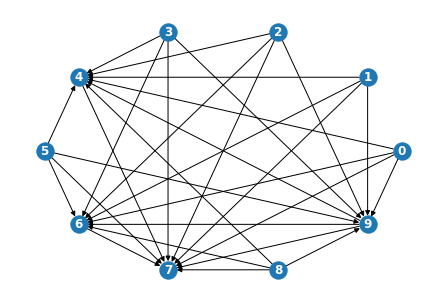

In [643]:
mydraw(out_bin)

In [633]:
Y_train[0]

array([[0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
       [1., 1., 0., 0., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 1., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]], dtype=float32)

In [634]:
count_accuracy(out_bin, Y_train[0])

{'fdr': 0.4, 'tpr': 0.6206896551724138, 'fpr': 0.75, 'shd': 22, 'nnz': 30}

In [635]:
out = model(X_test)[0].numpy()
out_bin = (out > 0.5).astype(float)
out_bin

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 0.]])

In [636]:
is_dag(out_bin)

True

In [637]:
Y_test[0].sum()

30.0

In [638]:
out_bin.sum()

25.0

In [639]:
Y_test[0]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 1., 1., 0., 0., 1., 1., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1., 1., 1., 0., 1.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [640]:
count_accuracy(out_bin, Y_test[0])

{'fdr': 0.5, 'tpr': 0.6, 'fpr': 0.75, 'shd': 25, 'nnz': 30}

# Non-linear

# Test NOTEARS

In [181]:
!pip install scipy

     |████████████████████████████████| 39.3 MB 2.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [182]:
import scipy.linalg as slin
import scipy.optimize as sopt
from scipy.special import expit as sigmoid

In [183]:

def notears_linear(X, lambda1, loss_type, max_iter=100, h_tol=1e-8, rho_max=1e+16, w_threshold=0.3):
    """Solve min_W L(W; X) + lambda1 ‖W‖_1 s.t. h(W) = 0 using augmented Lagrangian.

    Args:
        X (np.ndarray): [n, d] sample matrix
        lambda1 (float): l1 penalty parameter
        loss_type (str): l2, logistic, poisson
        max_iter (int): max num of dual ascent steps
        h_tol (float): exit if |h(w_est)| <= htol
        rho_max (float): exit if rho >= rho_max
        w_threshold (float): drop edge if |weight| < threshold

    Returns:
        W_est (np.ndarray): [d, d] estimated DAG
    """
    def _loss(W):
        """Evaluate value and gradient of loss."""
        M = X @ W
        if loss_type == 'l2':
            R = X - M
            loss = 0.5 / X.shape[0] * (R ** 2).sum()
            G_loss = - 1.0 / X.shape[0] * X.T @ R
        elif loss_type == 'logistic':
            loss = 1.0 / X.shape[0] * (np.logaddexp(0, M) - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (sigmoid(M) - X)
        elif loss_type == 'poisson':
            S = np.exp(M)
            loss = 1.0 / X.shape[0] * (S - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (S - X)
        else:
            raise ValueError('unknown loss type')
        return loss, G_loss

    def _h(W):
        """Evaluate value and gradient of acyclicity constraint."""
        E = slin.expm(W * W)  # (Zheng et al. 2018)
        h = np.trace(E) - d
        #     # A different formulation, slightly faster at the cost of numerical stability
        #     M = np.eye(d) + W * W / d  # (Yu et al. 2019)
        #     E = np.linalg.matrix_power(M, d - 1)
        #     h = (E.T * M).sum() - d
        G_h = E.T * W * 2
        return h, G_h

    def _adj(w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        return (w[:d * d] - w[d * d:]).reshape([d, d])

    def _func(w):
        """Evaluate value and gradient of augmented Lagrangian for doubled variables ([2 d^2] array)."""
        W = _adj(w)
        loss, G_loss = _loss(W)
        h, G_h = _h(W)
        obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
        G_smooth = G_loss + (rho * h + alpha) * G_h
        g_obj = np.concatenate((G_smooth + lambda1, - G_smooth + lambda1), axis=None)
        return obj, g_obj

    n, d = X.shape
    w_est, rho, alpha, h = np.zeros(2 * d * d), 1.0, 0.0, np.inf  # double w_est into (w_pos, w_neg)
    bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]
    if loss_type == 'l2':
        X = X - np.mean(X, axis=0, keepdims=True)
    for _ in range(max_iter):
        w_new, h_new = None, None
        while rho < rho_max:
            sol = sopt.minimize(_func, w_est, method='L-BFGS-B', jac=True, bounds=bnds)
            w_new = sol.x
            h_new, _ = _h(_adj(w_new))
            if h_new > 0.25 * h:
                rho *= 10
            else:
                break
        w_est, h = w_new, h_new
        alpha += rho * h
        if h <= h_tol or rho >= rho_max:
            break
    W_est = _adj(w_est)
    W_est[np.abs(W_est) < w_threshold] = 0
    return W_est


In [178]:
import shutil

In [176]:
os.rmdir?

Signature: os.rmdir(path, *, dir_fd=None)
Docstring:
Remove a directory.

If dir_fd is not None, it should be a file descriptor open to a directory,
  and path should be relative; path will then be relative to that directory.
dir_fd may not be implemented on your platform.
  If it is unavailable, using it will raise a NotImplementedError.
Type:      builtin_function_or_method


In [177]:
def run_expt(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name):
    if os.path.exists(expt_name):
        shutil.rmtree(expt_name)
    os.mkdir(expt_name)
    os.chmod(expt_name, 0o777)
    perf = defaultdict(list)
    for ii in tqdm(range(num_graph)):
        B_true = simulate_dag(d, s0, graph_type)
        W_true = simulate_parameter(B_true, w_ranges=w_ranges)
        W_true_fn = os.path.join(expt_name, f'graph{ii:05}_W_true.csv')
        np.savetxt(W_true_fn, W_true, delimiter=',')
        for jj in range(num_data_per_graph):
            X = simulate_linear_sem(W_true, n, sem_type, noise_scale=noise_scale)
            X_fn = os.path.join(expt_name, f'graph{ii:05}_data{jj:05}_X.csv')
            np.savetxt(X_fn, X, delimiter=',')
            # notears
            W_notears = notears_linear(X, lambda1=0, loss_type='l2')
            assert is_dag(W_notears)
            W_notears_fn = os.path.join(expt_name, f'graph{ii:05}_data{jj:05}_W_notears.csv')
            np.savetxt(W_notears_fn, W_notears, delimiter=',')
            # eval
            B_notears = (W_notears != 0)
            acc = count_accuracy(B_true, B_notears)
            for metric in acc:
                perf[metric].append(acc[metric])
    # print stats
    print(expt_name)
    for metric in perf:
        print(metric, f'{np.mean(perf[metric]):.4f}', '+/-', f'{np.std(perf[metric]):.4f}')


In [156]:

def main():
    set_random_seed(123)

    num_graph = 1000
    num_data_per_graph = 1

    n, d, s0, graph_type, sem_type = np.inf, 2, 1, 'ER', 'gauss'

    # equal variance
    w_ranges = ((-2.0, -0.5), (0.5, 2.0))
    noise_scale = [1., 1.]
    expt_name = 'equal_var'
    run_expt(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name)

    # large a
    w_ranges = ((-2.0, -1.1), (1.1, 2.0))
    noise_scale = [1., 0.15]
    expt_name = 'large_a'
    run_expt(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name)

    # small a
    w_ranges = ((-0.9, -0.5), (0.5, 0.9))
    noise_scale = [1, 0.15]
    expt_name = 'small_a'
    run_expt(num_graph, num_data_per_graph, n, d, s0, graph_type, sem_type, w_ranges, noise_scale, expt_name)


In [170]:
!pip install tqdm

     |████████████████████████████████| 76 kB 2.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [171]:
from collections import defaultdict
from tqdm import tqdm

In [167]:
pwd()

'/DAG-EQ/pysrc'

In [184]:
main()

100%|██████████| 1000/1000 [01:24<00:00, 11.84it/s]


equal_var
fdr 0.4930 +/- 0.5000
tpr 0.5070 +/- 0.5000
fpr 0.4930 +/- 0.5000
shd 0.4930 +/- 0.5000
nnz 1.0000 +/- 0.0000


 33%|███▎      | 332/1000 [00:25<00:54, 12.31it/s]/tmp/ipykernel_31/3013478402.py:42: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W * 2
100%|██████████| 1000/1000 [01:17<00:00, 12.92it/s]


large_a
fdr 0.0180 +/- 0.1330
tpr 0.9820 +/- 0.1330
fpr 0.0180 +/- 0.1330
shd 0.0180 +/- 0.1330
nnz 1.0000 +/- 0.0000


 45%|████▍     | 446/1000 [00:32<00:41, 13.23it/s]/tmp/ipykernel_31/3013478402.py:54: RuntimeWarning: overflow encountered in double_scalars
  obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
/tmp/ipykernel_31/3013478402.py:55: RuntimeWarning: overflow encountered in multiply
  G_smooth = G_loss + (rho * h + alpha) * G_h
100%|██████████| 1000/1000 [01:12<00:00, 13.79it/s]

small_a
fdr 0.4520 +/- 0.4977
tpr 0.5480 +/- 0.4977
fpr 0.4520 +/- 0.4977
shd 0.4520 +/- 0.4977
nnz 1.0000 +/- 0.0000


In [185]:
main()

 16%|█▌        | 155/1000 [00:13<01:12, 11.71it/s]

KeyboardInterrupt

